In [1]:
import numpy as np
from source.Files_operating import read_sht_data
from source.Peaks_processing import *

shtRipper v1.3


In [2]:
import time
import random

from matplotlib.colors import CSS4_COLORS as COLORS

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator

colors = ['gold', 'brown', 'black', 'seagreen', 'skyblue', 'cyan', 'yellow', 'violet', 'royalblue', 'sandybrown', 'grey', 'gray', 'indigo', 'rosybrown', 'darkviolet', 'coral', 'pink', 'magenta', 'red', 'springgreen', 'darkblue', 'silver', 'seashell', 'green', 'navy', 'purple', 'sienna', 'chocolate', 'orange', 'blue']

In [4]:
F_ID = 44184
proj_path = "D:/Edu/Lab/Projects/Plasma_analysis"
# D:/Edu/Lab/Projects/Plasma_analysis | C:/Users/f.belous/Work/Projects/Plasma_analysis
sht_dir_path = proj_path + "/data/sht/all/"  

df = read_sht_data(f'sht{F_ID}', sht_dir_path)
df = df.rename(columns={"ch1": "d_alpha"})
df["sxr"] = read_sht_data(f'sht{F_ID}', sht_dir_path, data_name="SXR 50 mkm").ch1
df["nl"] = read_sht_data(f'sht{F_ID}', sht_dir_path, data_name="nl 42 cm (1.5мм) 64pi").ch1
# df["mgd4"] = read_sht_data(f'mhed{F_ID}', mgd_dir_path, data_name="МГД4").ch1
# dbs = read_dataFile(f'data/dbs/{F_ID} DBS.dat')
# mgd_data_tor
# mgd_data_vertical
df["mgd_v"] = read_sht_data(f'sht{F_ID}', sht_dir_path, data_name="МГД быстрый зонд верт.").ch1
# mgd_data_radial
df["mgd_r"] = read_sht_data(f'sht{F_ID}', sht_dir_path, data_name="МГД быстрый зонд рад.").ch1

mgd = df.mgd_v.to_numpy() ** 2 + df.mgd_r.to_numpy() ** 2

df.describe()

,t,d_alpha,sxr,nl,mgd_v,mgd_r
count,393216.000000,393216.000000,393216.000000,393216.000000,393216.000000,393216.000000
mean,0.196608,0.281714,0.386184,21.365807,-0.002304,-0.006000
std,0.113512,0.393401,0.503047,8.429814,0.085549,0.096789
min,0.000000,-0.388535,-0.076685,-5.902667,-5.235000,-5.235000
25%,0.098304,0.012781,0.107358,16.061839,-0.005112,-0.010225
50%,0.196607,0.066460,0.109915,20.788676,-0.002556,-0.005112
75%,0.294911,0.575134,0.439658,30.783231,0.002556,-0.002556
max,0.393215,4.818347,2.356772,48.138483,5.232444,5.232444


In [5]:
d_alpha = df.d_alpha.to_numpy()
sxr = df.sxr.to_numpy()

In [6]:
d_alpha_d1 = np.diff(d_alpha)
sxr_d1 = np.diff(sxr)

In [7]:
from scipy import signal
from source.NN_environment import normalise_series
from sklearn.preprocessing import normalize

# def normalise_series(data):
#     max_value, min_value, mean_value = np.max(data), np.min(data), np.mean(data)
#     return (data - mean_value) / abs(max_value - min_value)

def filt_signal(arr, N, W):
    b, a = signal.butter(N, W)
    return signal.filtfilt(b, a, arr)

def smooth_rect(y, box_pts):
    box = np.ones(box_pts) / box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

def smooth_gauss(y, box_pts, sigma=1):
    x = np.arange(box_pts) - box_pts / 2
    box = 1 / sigma / (2 * np.pi) ** 0.5 * np.exp(-x ** 2 / 2 / sigma ** 2)
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

def smooth_steklov(y, box_pts, ro=0.1):    
    c = 1 / 0.4439938161681
    x_ro = (np.arange(box_pts) - box_pts / 2) / (box_pts / 2 * ro)
    box = np.zeros(box_pts)
    box[abs(x_ro) < 1] = 1 / (box_pts / 2 * ro) * c * np.exp(1 / (x_ro[abs(x_ro) < 1] ** 2 - 1))
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

d_alpha_f = filt_signal(d_alpha_d1, 5, 0.1)
sxr_f = filt_signal(sxr_d1, 5, 0.05)

In [8]:
dbs_dir_path = proj_path + "/data/dbs/sht/"
dbs_df = read_sht_data(f'Dref{F_ID}', dbs_dir_path, data_name="ch1")
channels = [1, 2, 3, 4]
for i in channels[1:]:
    dbs_df[f"ch{i}"] = read_sht_data(f'Dref{F_ID}', dbs_dir_path, data_name=f"ch{i}").ch1

dbs_df.describe()

,t,ch1,ch2,ch3,ch4
count,512000.000000,512000.000000,512000.000000,512000.000000,512000.000000
mean,0.164000,0.056893,0.150608,0.156078,0.136923
std,0.036951,0.306641,0.692173,0.190068,0.190111
min,0.100000,-1.636719,-4.000000,-1.193359,-1.324219
25%,0.132000,-0.068359,-0.126953,0.074219,0.056641
50%,0.164000,0.060547,0.152344,0.158203,0.136719
75%,0.196000,0.173828,0.423828,0.234375,0.216797
max,0.228000,2.519531,3.998047,1.802734,1.533203


In [27]:
for ind in range(1, len(channels) + 1, 2):
    w = 0.8
    smooth_lenght = 500
    i_data = dbs_df[f"ch{ind}"].to_numpy() # normalise_series() filt_signal( , 5, w)  smooth_steklov( , smooth_lenght, smooth_lenght / 2)
    i_data /= np.linalg.norm(i_data)
    q_data = dbs_df[f"ch{ind + 1}"].to_numpy()
    q_data /= np.linalg.norm(q_data)

    c_data = filt_signal(i_data, 5, w) + filt_signal(q_data, 5, w)*1j

    fi_data = np.angle(c_data)

    dbs_df[f"ch{ind}_A"] = smooth_steklov(np.abs(c_data), smooth_lenght, 0.8)
    dbs_df[f"ch{ind}_dfi"] = smooth_steklov(np.concatenate([np.abs(np.diff(fi_data)), [0]]), smooth_lenght, 0.4)  # np.concatenate([np.diff(), [0]]) smooth_gauss(np.concatenate([filt_signal(np.diff(np.angle(c_data)), 5, w), [0]]), 300)

dbs_df.describe()

,t,ch1,ch2,ch3,ch4,ch1_A,ch1_dfi,ch3_A,ch3_dfi
count,512000.000000,512000.000000,512000.000000,512000.000000,512000.000000,512000.000000,512000.000000,512000.000000,512000.000000
mean,0.164000,0.000255,0.000297,0.000887,0.000817,0.001485,0.371856,0.001697,0.246404
std,0.036951,0.001374,0.001366,0.001080,0.001134,0.000842,0.300712,0.000466,0.201107
min,0.100000,-0.007334,-0.007892,-0.006781,-0.007899,0.000115,0.009369,0.000509,0.022055
25%,0.132000,-0.000306,-0.000250,0.000422,0.000338,0.000781,0.076028,0.001297,0.061550
50%,0.164000,0.000271,0.000301,0.000899,0.000816,0.001380,0.331667,0.001661,0.201445
75%,0.196000,0.000779,0.000836,0.001332,0.001293,0.002038,0.605854,0.002021,0.378442
max,0.228000,0.011290,0.007888,0.010244,0.009146,0.003978,1.782497,0.003735,1.191562


---
---

In [10]:
df_arr = []  # l_edge, r_edge, n, fr, fr_std

In [11]:
meta_sxr = Signal_meta(chanel_name="sxr", processing_flag=True)
meta_sxr.set_statistics(sxr, sxr_f, 0.8, 0.8, d_std_bottom_edge=7., d_std_top_edge=13.0)
meta_sxr.set_edges(length_edge=5, distance_edge=30, scale=0, step_out=20)

In [12]:
mark_data = np.zeros(sxr_f.shape)
mark_data[abs(sxr_f - meta_sxr.d_q) > meta_sxr.d_std * meta_sxr.d_std_bottom] = 1
mark_sxr = proc_slices(mark_data, sxr, sxr_f, meta_sxr)

In [13]:
# get slices from standart sxr proccessing
sxr_slices = get_slices(mark_sxr)  # [Slice(0, 0)] + 
slices_edges = []
step_out = 50

len_top = 5000
len_width = 3000
len_step = 2000

# get slices btw sxr falls
slices_edges.append([sxr_slices[0].r + step_out, 0])
for i in range(1, len(sxr_slices)):
    cur_l_edge = slices_edges[-1][0]
    while sxr_slices[i].l - step_out - cur_l_edge > len_top:
        slices_edges[-1][1] = cur_l_edge + len_width
        slices_edges.append([cur_l_edge + len_width, 0])
        cur_l_edge += len_step
    
    slices_edges[-1][1] = sxr_slices[i].l - step_out
    slices_edges.append([sxr_slices[i].r + step_out, 0])

slices_edges[-1][1] = min(sxr_slices[-1].r + 1000, sxr.shape[0] - step_out)
slices_edges = np.array(slices_edges)
print(slices_edges)

[[175528 178528]
 [178528 180528]
 [180528 182528]
 [182528 185691]
 [185872 189111]
 [189326 192968]
 [193150 196515]
 [196698 199847]
 [200046 203590]
 [203801 208077]
 [208296 212556]
 [212763 215904]
 [216086 219157]
 [219364 222135]
 [222321 224995]
 [225200 228011]
 [228217 231020]
 [231209 233392]
 [233579 235508]
 [235687 237929]
 [238128 240160]
 [240333 241934]
 [242111 243642]
 [243813 245122]
 [245285 246439]
 [246590 251279]
 [251432 256033]
 [256151 257101]]


In [14]:
# proccess Slice(0, 1st sxr fall)
first_slice = Slice(150, sxr_slices[0].l + step_out)
print(first_slice)

d_alpha_slice = d_alpha[first_slice.l: first_slice.r]
d_alpha_f_slice = d_alpha_f[first_slice.l: first_slice.r]

meta_da = Signal_meta(chanel_name="da", processing_flag=True)
meta_da.set_statistics(d_alpha, d_alpha_f, 0.7, 0.7, d_std_bottom_edge=2., d_std_top_edge=1.0)
meta_da.set_edges(length_edge=50, distance_edge=100)

mark_data = np.zeros(d_alpha_f_slice.shape)
mark_data[abs(d_alpha_f_slice - meta_da.d_q) > meta_da.d_std * meta_da.d_std_bottom] = 1
# mark_d_alpha = proc_slices(mark_data, d_alpha_slice, d_alpha_f_slice, meta_da)

da_slices = get_slices(mark_data)  # list(filter(lambda x: x.check_length(10), get_slices(mark_d_alpha)))

first_slice_edges = []
dist_top = 1000
step_out = 100

first_slice_edges.append([max(0, da_slices[0].l - step_out), da_slices[0].r + step_out])
for i in range(len(da_slices)):
    if da_slices[i].l - first_slice_edges[-1][1] > dist_top:
        first_slice_edges.append([da_slices[i].l - step_out, da_slices[i].l])
    elif first_slice_edges[-1][1] - first_slice_edges[-1][0] > len_top:
        first_slice_edges.append([first_slice_edges[-1][1] - step_out, first_slice_edges[-1][1]])
    first_slice_edges[-1][1] = da_slices[i].r + step_out
        

first_slice_edges = np.array(first_slice_edges) + 150
print(len(first_slice_edges))

(150, 175479)
15


In [15]:
res_slices_edges = np.concatenate([first_slice_edges, slices_edges]).astype(np.int64)  # slices_edges.astype(np.int64)

res_slices_marks = np.zeros(len(res_slices_edges))
print(len(res_slices_edges))

43


---
---


------
------

10/43 - Slice (195.76, 195.85) ms - mark: 0.0 (1 - dELM, 2 - LCO, 3 - EHO) - 1 peaks - 7.080 ms


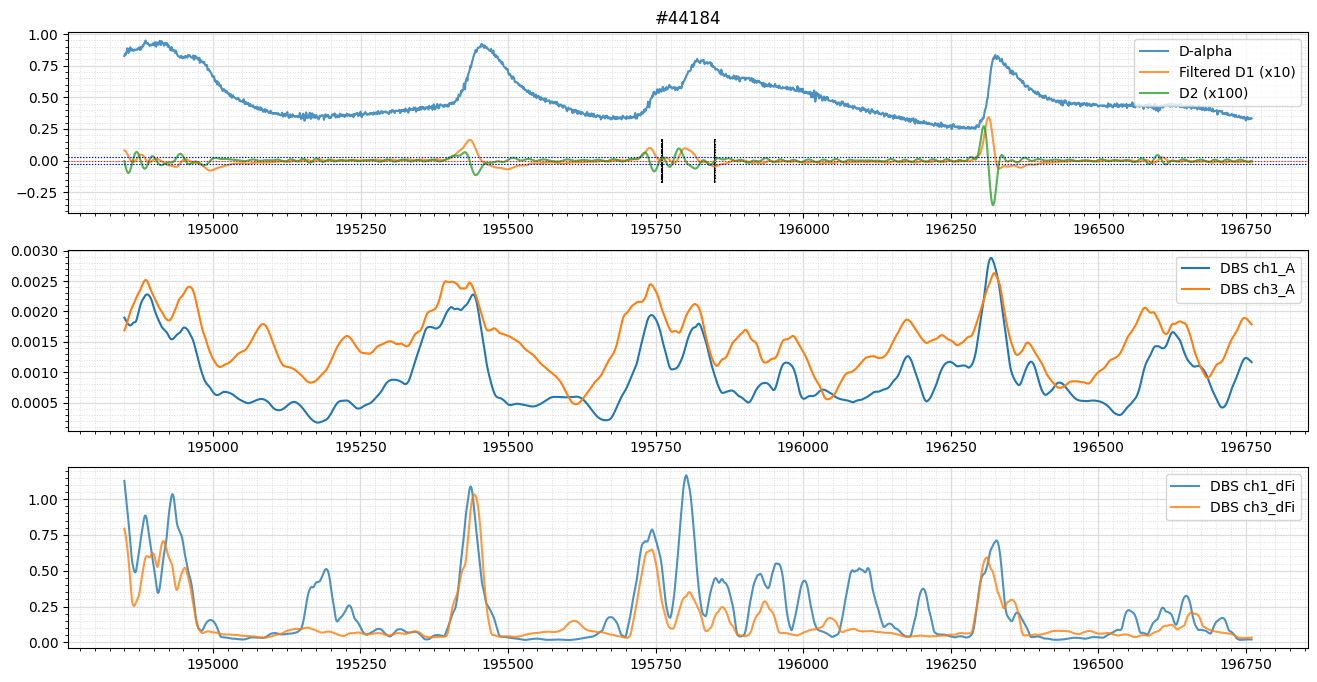

KeyboardInterrupt: Interrupted by user

In [45]:
start_ind = 9  # 0

for ind in range(start_ind, res_slices_edges.shape[0]):
    l_edge, r_edge = 195760, 195850  # res_slices_edges[ind]
    plot_l_edge, plot_r_edge = l_edge, r_edge

    if plot_r_edge - plot_l_edge < 1000:
        increasing_d = 1000  - (plot_r_edge - plot_l_edge)
        plot_l_edge -= increasing_d
        plot_r_edge += increasing_d

    fig, axs = plt.subplots(nrows=3, gridspec_kw={'hspace': 0.2})  # , sharex=True
    
    fig.set_figwidth(16)
    fig.set_figheight(8)
    
    axs[0].set_title(f"#{F_ID}")
    
    b, a = signal.butter(5, 0.1)
    d_alpha_d2f = signal.filtfilt(b, a, np.diff(d_alpha_f))
    
    axs[0].plot(range(plot_l_edge, plot_r_edge), d_alpha[plot_l_edge:plot_r_edge], label="D-alpha", alpha=0.8, zorder=2)
    # axs[0].plot(range(l_edge, r_edge), d_alpha_d1[l_edge:r_edge], label="Diff 1")
    axs[0].plot(range(plot_l_edge, plot_r_edge), d_alpha_f[plot_l_edge:plot_r_edge] * 10, label="Filtered D1 (x10)", alpha=0.8)
    axs[0].plot(range(plot_l_edge, plot_r_edge), d_alpha_d2f[plot_l_edge:plot_r_edge] * 100, label="D2 (x100)", alpha=0.8)
    axs[0].scatter([l_edge, r_edge], [0, 0], s=1000, color="black", marker="|", zorder=1)  # d_alpha[l_edge], d_alpha[r_edge]

    start_time = time.time()
    coef=1.
    x = get_d1_crosses(d_alpha_f, d_alpha_d2f, l_edge, r_edge, d1_coef=coef)
    print(f"\n------\n------\n\n{ind + 1}/{res_slices_edges.shape[0]} - Slice ({l_edge/1e3}, {r_edge/1e3}) ms - mark: {res_slices_marks[ind]} (1 - dELM, 2 - LCO, 3 - EHO) - {len(x)} peaks - {(time.time() - start_time)*1e3:.3f} ms")

    if len(x) > 1:
        print(f"Start prossecing peaks ...", end=" ")  # 
        start_time = time.time()
        res_groups_peaks = get_groups_from_signal(d_alpha, d_alpha_f, d_alpha_d2f, l_edge, r_edge)
        # print("- logg: ", res_groups_peaks)
        print(f"- Tooks: {(time.time() - start_time)*1e3:.3f} ms")
        for g_i in range(len(res_groups_peaks)):
            points = res_groups_peaks[g_i]
            c = colors[g_i % len(colors)]
            axs[0].scatter(points, d_alpha[points] + g_i * 0.05, s=20, color=c, zorder=0)
            
            m_d = get_time_delta(points) / 1e3
            std_d = 0


            for p_i in range(1, len(points)):
                std_d += (m_d - (points[p_i] - points[p_i - 1]) / 1e3) ** 2
            std_d = (std_d / len(points) / (len(points) - 1)) ** .5
            print(f"{g_i + 1}/{len(res_groups_peaks)} Group of peaks ({c}) - {len(points)} peaks in group - mean delta: {m_d:.3f} ms - freq: {1/m_d:.3f} +- {std_d/(m_d ** 2):.3f} kHz")
        
        for p_i in range(len(x)):
            num = p_i
            d = 0
            while num > 10:
                num = num // 10
                d += 1
            axs[0].annotate(p_i, (x[p_i] - (25) * (r_edge - l_edge) / 5000 - 15 * d, d_alpha[x[p_i]] + 0.03))
            for ax in axs:
                ax.axvline(x[p_i], linestyle=':', color='k', alpha=0.7)
    
    axs[0].axhline(d_alpha_f.mean(), color="red", linestyle=':', linewidth=0.8)
    axs[0].axhline((d_alpha_f.mean() + d_alpha_f.std()) * 10 * coef, color="green", linestyle=':', linewidth=0.8)
    axs[0].axhline((d_alpha_f.mean() - d_alpha_f.std()) * 10 * coef, color="green", linestyle=':', linewidth=0.8)
    axs[0].axhline((d_alpha_d2f.mean() + d_alpha_d2f.std()) * 100, color="blue", linestyle=':', linewidth=0.8)
    axs[0].axhline((d_alpha_d2f.mean() - d_alpha_d2f.std()) * 100, color="blue", linestyle=':', linewidth=0.8)
    axs[0].grid(which='major', color='#DDDDDD', linewidth=0.9)
    axs[0].grid(which='minor', color='#DDDDDD', linestyle=':', linewidth=0.7)
    axs[0].minorticks_on()
    axs[0].xaxis.set_minor_locator(AutoMinorLocator(10))
    axs[0].legend(loc='lower right')

    for i in channels[::2]:  # channels[::2]
        time_mask = np.array((dbs_df.t * 1e6 >= plot_l_edge) & (dbs_df.t * 1e6 <= plot_r_edge))
        axs[1].plot(np.linspace(plot_l_edge, plot_r_edge, np.count_nonzero(time_mask)), dbs_df[f"ch{i}_A"][time_mask], label=f"DBS ch{i}_A")  # filt_signal(
        axs[2].plot(np.linspace(plot_l_edge, plot_r_edge, np.count_nonzero(time_mask)), dbs_df[f"ch{i}_dfi"][time_mask], label=f"DBS ch{i}_dFi", alpha=0.8)

    for ax in axs:
        ax.grid(which='major', color='#DDDDDD', linewidth=0.9)
        ax.grid(which='minor', color='#DDDDDD', linestyle=':', linewidth=0.7)
        ax.minorticks_on()
        ax.xaxis.set_minor_locator(AutoMinorLocator(10))
        ax.legend(loc='upper right')
    
    plt.show()
    
    mode = input("Input mode [manual (input points) - 0 | auto (input group) - 1 | continue - -1]: ")
    while mode != "" and int(mode) >= 0:
        mode = int(mode)
        if mode == 0:
            points_ind = list(map(int, input("Input point indexes:\n").strip().split()))
            points = x[points_ind]
        else:
            gr_ind = int(input(f"Input group number (from 1 to {len(res_groups_peaks)}): ").strip().split()[0]) - 1
            points = res_groups_peaks[gr_ind]
        
        m_d = get_time_delta(points) / 1e3

        mark = input("Input mark of the group (string: eho|lco|delm)")
        for p in points:
            df_arr.append([p, 1 / m_d, mark])
        
        mode = input("Input mode [manual (input points) - 0 | auto (input group) - 1 | continue - -1]: ")

In [19]:
# l_edge, r_edge, n, fr, fr std
df = pd.DataFrame(df_arr, columns=["timepoint", "fr, kHz", "mark"])
df.head(10)

,timepoint,"fr, kHz",mark
0,151950,4.424779,lco
1,152160,4.424779,lco
2,152402,4.424779,lco
3,152616,4.901961,lco
4,152803,4.901961,lco
5,153024,4.901961,lco
6,153228,4.901961,lco
7,153762,3.428571,lco
8,154074,3.428571,lco
9,154385,3.428571,lco


In [20]:
df.to_csv(f"data/df/stats/{F_ID}_points_dataset", index=False)

---
---

In [10]:
points_df = pd.read_csv(f"data/df/stats/{F_ID}_points_dataset.csv")
print(points_df)

     timepoint   fr, kHz  mark
0       151950  4.424779   lco
1       152160  4.424779   lco
2       152402  4.424779   lco
3       152616  4.901961   lco
4       152803  4.901961   lco
..         ...       ...   ...
99      204942  1.672241  delm
100     205396  1.672241  delm
101     209246  1.930502  delm
102     209873  1.930502  delm
103     210282  1.930502  delm

[104 rows x 3 columns]


In [127]:
class Point: 
    def __init__(self, x, y): 
        self.x = x 
        self.y = y 
        
def get_area(x, y):
    n = len(x)
    area = 0
    for i in range(n):
        area += (x[i] * y[(i + 1) % n] - x[(i + 1) % n] * y[i])
    
    return 0.5 * area

def get_conv(x, y):
    convex = 0
    for i in range(len(x) - 2):
        v1 = np.array([x[i + 1] - x[i], y[i + 1] - y[i]])
        v2 = np.array([x[i + 2] - x[i + 1], y[i + 2] - y[i + 1]])
    
        cross_product = np.cross(v1, v2)
    
        if i == 0:
            sign = np.sign(cross_product)
        convex += sign * cross_product
    return convex

def get_intersections(x, y):
    """
    Подсчитывает количество самопересечений кривой, заданной массивами координат x и y.

    Args:
        x: Массив координат x.
        y: Массив координат y.

    Returns:
        Количество самопересечений.
    """
    step_out = 50
    intersections = []

    for i in range(len(x) - 1):
        for j in range(i - step_out):
            # Проверка пересечения отрезков (i, i + 1) и (j, j + 1)
            if doIntersect(Point(x[j], y[j]), Point(x[j + 1], y[j + 1]), Point(x[i], y[i]), Point(x[i + 1], y[i + 1])):
                intersections.append([j,i])

    return intersections
  
# Given three collinear points p, q, r, the function checks if  
# point q lies on line segment 'pr'  
def onSegment(p, q, r): 
    if ( (q.x <= max(p.x, r.x)) and (q.x >= min(p.x, r.x)) and 
           (q.y <= max(p.y, r.y)) and (q.y >= min(p.y, r.y))): 
        return True
    return False
  
def orientation(p, q, r): 
    # to find the orientation of an ordered triplet (p,q,r) 
    # function returns the following values: 
    # 0 : Collinear points 
    # 1 : Clockwise points 
    # 2 : Counterclockwise 
      
    # See https://www.geeksforgeeks.org/orientation-3-ordered-points/amp/  
    # for details of below formula.  
      
    val = (float(q.y - p.y) * (r.x - q.x)) - (float(q.x - p.x) * (r.y - q.y)) 
    if (val > 0): 
          
        # Clockwise orientation 
        return 1
    elif (val < 0): 
          
        # Counterclockwise orientation 
        return 2
    else: 
          
        # Collinear orientation 
        return 0
  
# The main function that returns true if  
# the line segment 'p1q1' and 'p2q2' intersect. 
def doIntersect(p1,q1,p2,q2): 
      
    # Find the 4 orientations required for  
    # the general and special cases 
    o1 = orientation(p1, q1, p2) 
    o2 = orientation(p1, q1, q2) 
    o3 = orientation(p2, q2, p1) 
    o4 = orientation(p2, q2, q1) 
  
    # General case 
    if ((o1 != o2) and (o3 != o4)): 
        return True
  
    # Special Cases 
  
    # p1 , q1 and p2 are collinear and p2 lies on segment p1q1 
    if ((o1 == 0) and onSegment(p1, p2, q1)): 
        return True
  
    # p1 , q1 and q2 are collinear and q2 lies on segment p1q1 
    if ((o2 == 0) and onSegment(p1, q2, q1)): 
        return True
  
    # p2 , q2 and p1 are collinear and p1 lies on segment p2q2 
    if ((o3 == 0) and onSegment(p2, p1, q2)): 
        return True
  
    # p2 , q2 and q1 are collinear and q1 lies on segment p2q2 
    if ((o4 == 0) and onSegment(p2, q1, q2)): 
        return True
  
    # If none of the cases 
    return False

# def get_intersections(x, y):
#     part_sum = np.zeros((len(x), 2))
#     intersections = []
#     for i in range(len(x) - 1):
#         v1 = np.array([x[i + 1] - x[i], y[i + 1] - y[i]])
#         for j in range(i + 1):
#             if (np.all(part_sum[j] * (part_sum[j] + v1) <= 0)) and np.linalg.norm(part_sum[j]) != 0:
#                 intersections.append([j,i])
#             if np.any(part_sum[j] * (part_sum[j] + v1) <= 0) and np.any(part_sum[j + 1] * (part_sum[j + 1] + v1) <= 0) and np.linalg.norm(part_sum[j]) != 0:
#                 intersections.append([j,i])
#             part_sum[j] += v1
            
#     return intersections

Input point indexes:
 0 1 2


456
203
379
357


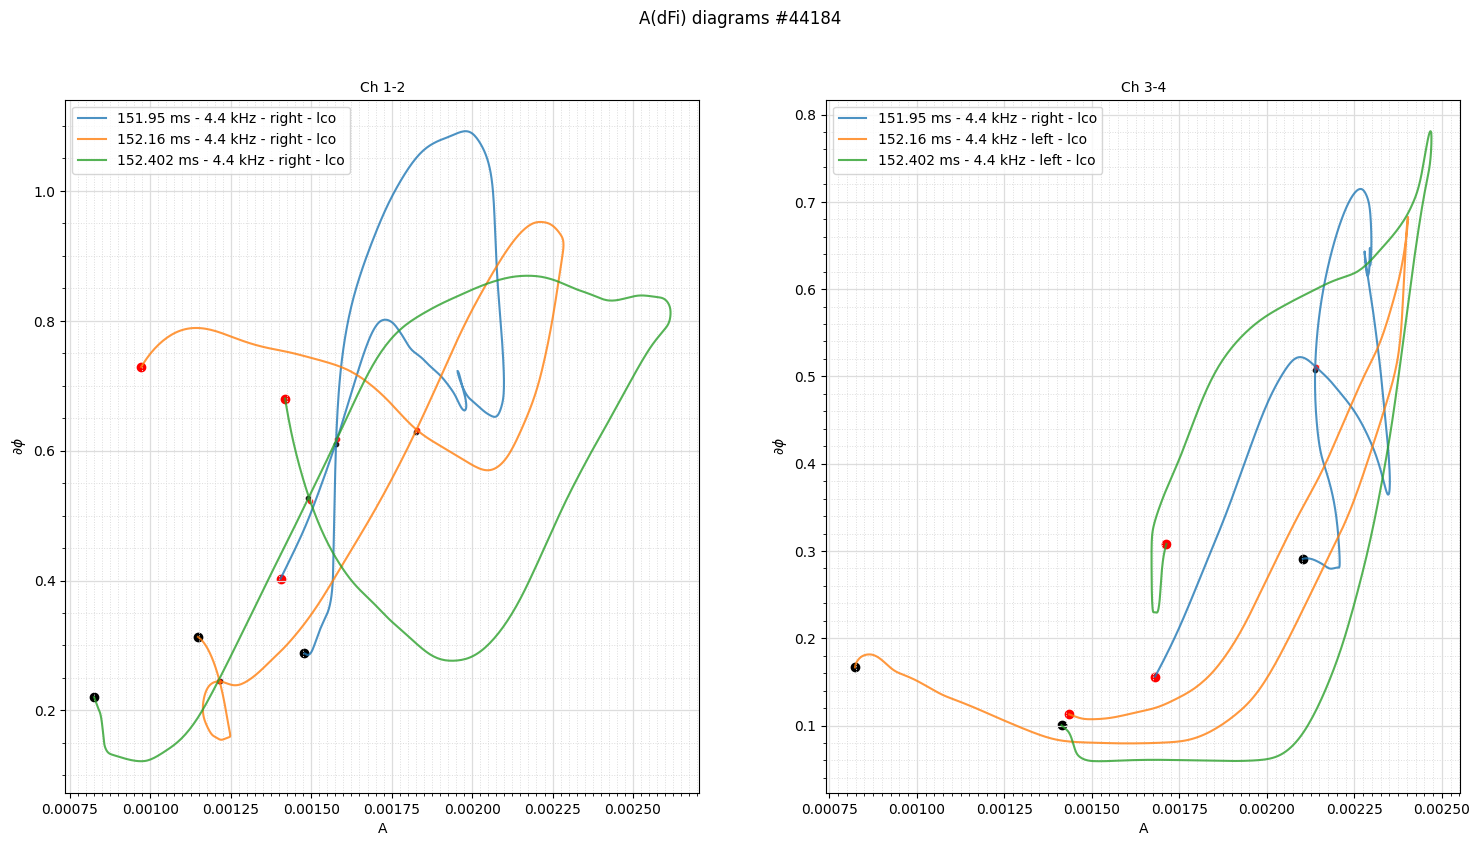

Diagram bypass prognose:
1/3: dELM
2/3: LCO
3/3: LCO

---



Input point indexes:
 4 8 28 58 87 89


401
281
298
126
413
477


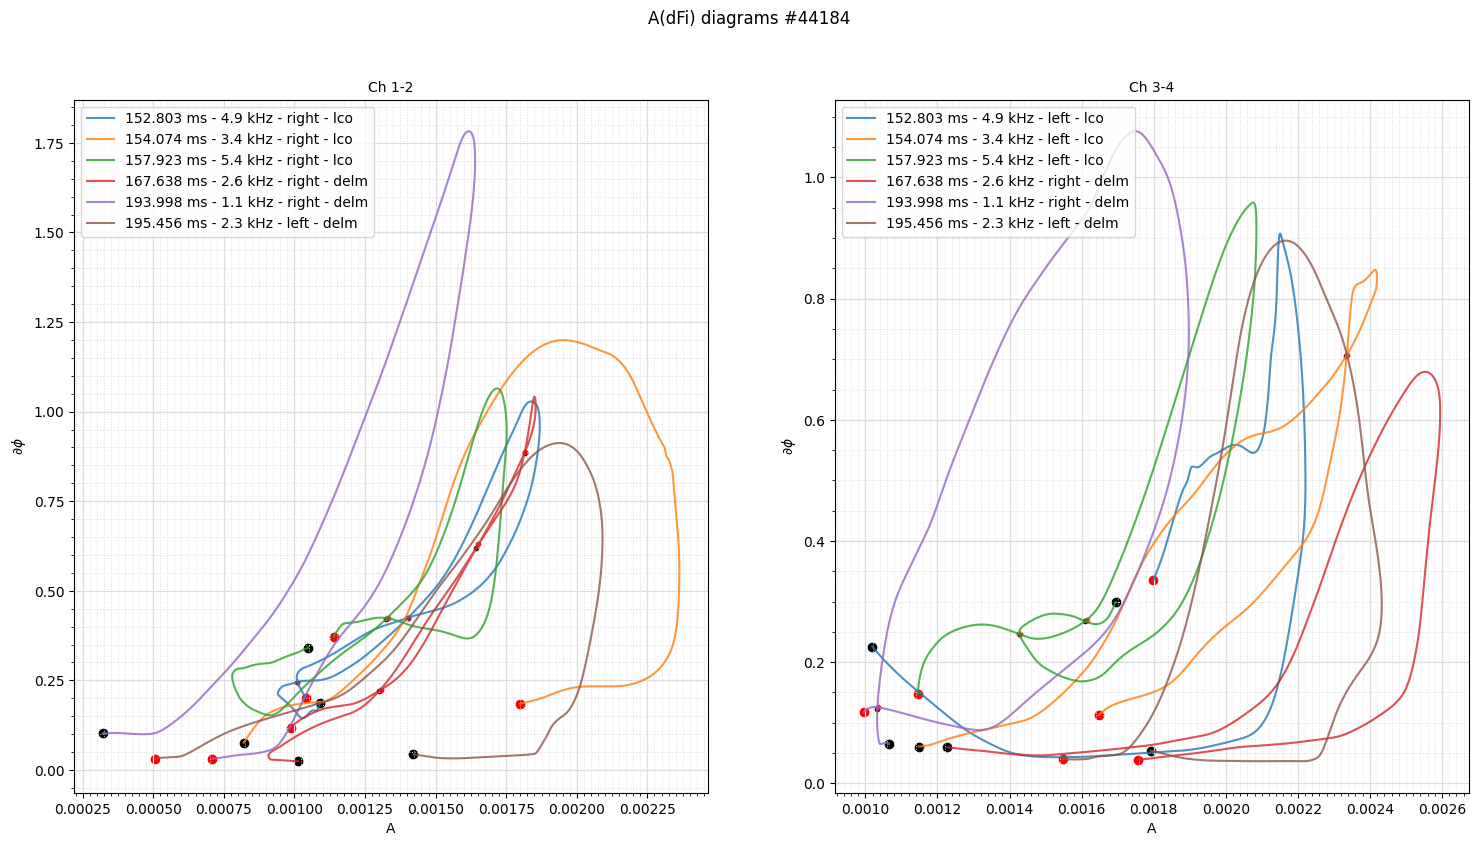

Diagram bypass prognose:
1/6: LCO
2/6: LCO
3/6: LCO
4/6: dELM
5/6: dELM
6/6: dELM

---



Input point indexes:
 90


349


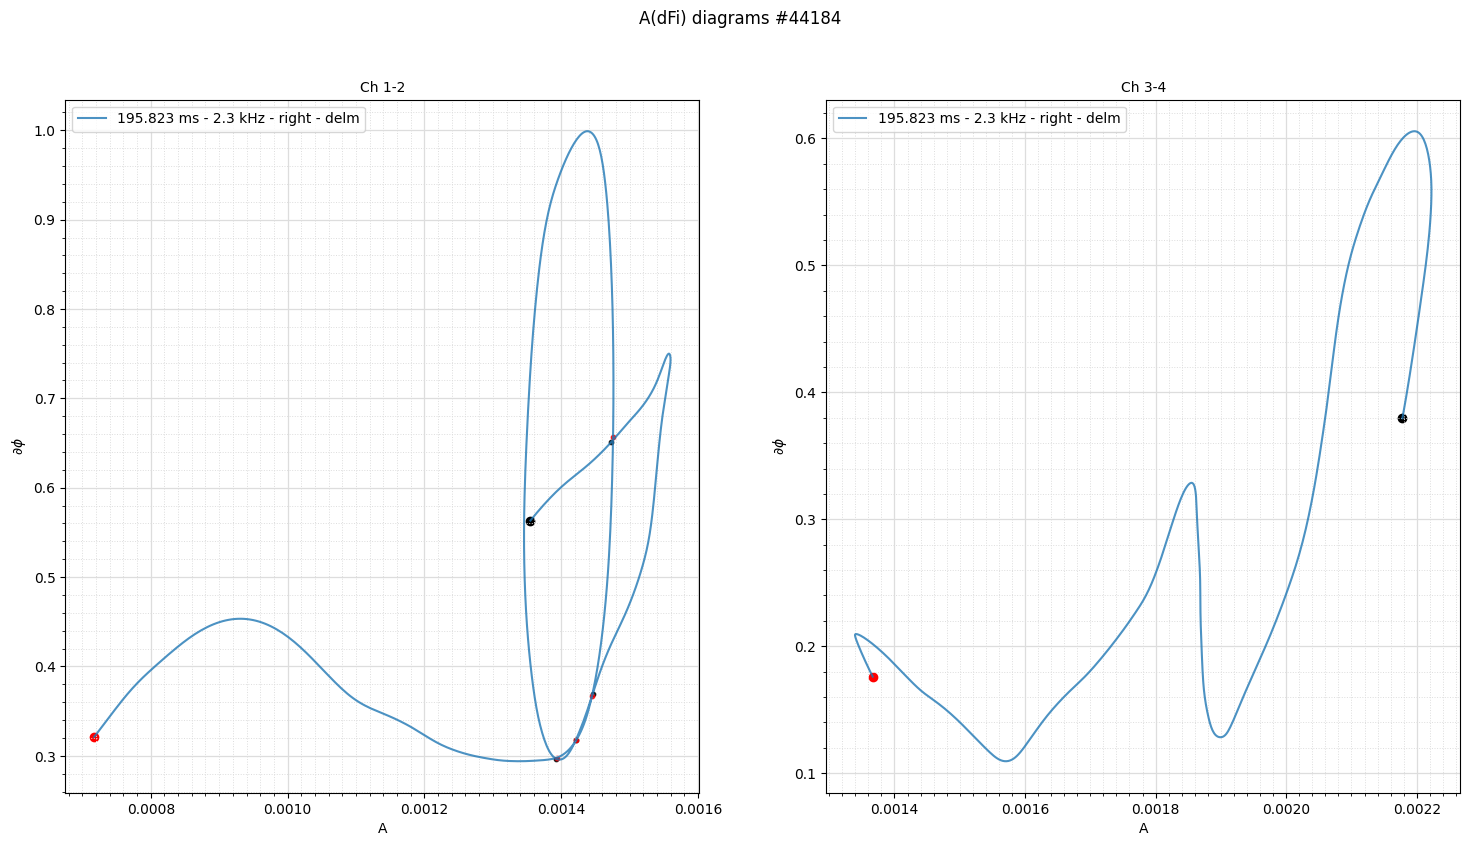

Diagram bypass prognose:
1/1: dELM

---



KeyboardInterrupt: Interrupted by user

In [129]:
time_points = points_df.timepoint.to_numpy()
marks = points_df.mark.to_numpy()
frequencies = points_df["fr, kHz"].to_numpy()

comm = input("Input point indexes:\n")
while len(comm) > 0:
    diagram_points_ind = list(map(int, comm.strip().split()))
    diagram_points = time_points[diagram_points_ind]

    instability_bypass = np.ones(len(diagram_points))

    fig, axs = plt.subplots(ncols=len(channels[::2]), gridspec_kw={'hspace': 0.1})  # , sharex=True
    fig.set_figwidth(18)
    fig.set_figheight(9)
    
    fig.suptitle(f"A(dFi) diagrams #{F_ID}")
    for ax_i, ch_i in enumerate(channels[::2]):
        axs[ax_i].set_title(f"Ch {ch_i}-{ch_i + 1}", fontsize="medium")
        # print(f"Areas for ch {ch_i}-{ch_i + 1}:")
        for p_i in range(len(diagram_points)):
            if marks[diagram_points_ind[p_i]] == "delm":
                step_out = [100, 50]
            elif marks[diagram_points_ind[p_i]] == "lco":
                step_out = [100, 50]
            elif marks[diagram_points_ind[p_i]] == "eho":
                step_out = [45, 40]
            else:
                step_out = [100, 50]
            time_mask = np.array((dbs_df.t * 1e6 >= diagram_points[p_i] - step_out[0]) & (dbs_df.t * 1e6 <= diagram_points[p_i] + step_out[1]))
            a = dbs_df[f"ch{ch_i}_A"][time_mask].to_numpy()
            dfi = dbs_df[f"ch{ch_i}_dfi"][time_mask].to_numpy()
            # print(dbs_df.t.to_numpy()[time_mask][9*40], dbs_df.t.to_numpy()[time_mask][16*40])
            
            edges = [0, -1]
            
            intersections = sorted(get_intersections(a, dfi), key=lambda x: x[1] - x[0], reverse=True)
            if len(intersections) > 0:  #  and intersections[0][1] - intersections[0][0] > 400
                print(intersections[0][1] - intersections[0][0])
                edges = intersections[0]
                axs[ax_i].scatter(a[np.array(intersections)[:, 0]], dfi[np.array(intersections)[:, 0]], color="k", s=10, alpha=0.8)
                axs[ax_i].scatter(a[np.array(intersections)[:, 1]], dfi[np.array(intersections)[:, 1]], color="r", s=10, alpha=0.8)
            bypass = np.sign(get_area(a[edges[0]:edges[1]], dfi[edges[0]:edges[1]]))
            instability_bypass[p_i] *= bypass
            
            axs[ax_i].plot(a, dfi,
                           label=f"{diagram_points[p_i]/1e3} ms - {frequencies[diagram_points_ind[p_i]]:.1f} kHz - {'left' if bypass > 0 else 'right'} - {marks[diagram_points_ind[p_i]]}", alpha=0.8)
            axs[ax_i].scatter(a[0], dfi[0], color="k")
            axs[ax_i].scatter(a[-1], dfi[-1], color="r")
            # axs[ax_i].scatter(a[::40], dfi[::40], color="b", s=5)

            # print(f"{p_i + 1}/{len(diagram_points)}: {get_area(a[edges[0]:edges[1]], dfi[edges[0]:edges[1]]) * 1e5:.1f} | {intersections} (len: {len(a)})")
        axs[ax_i].set_xlabel("A")
        axs[ax_i].set_ylabel("$\partial\phi$")
        axs[ax_i].grid(which='major', color='#DDDDDD', linewidth=0.9)
        axs[ax_i].grid(which='minor', color='#DDDDDD', linestyle=':', linewidth=0.7)
        axs[ax_i].minorticks_on()
        axs[ax_i].xaxis.set_minor_locator(AutoMinorLocator(10))
        axs[ax_i].legend(loc='upper left')
    plt.show()

    print("Diagram bypass prognose:")
    for p_i in range(instability_bypass.shape[0]):
        print(f"{p_i + 1}/{len(diagram_points)}: {'dELM' if instability_bypass[p_i] > 0 else 'LCO'}")
    print("\n")
    
    comm = input("Input point indexes:\n")

# 4 8 28 35 69 74 90
# 4 8 28 58 87 90
# 195.763 195.833: 9 - 16 * 40

In [149]:
time_points = points_df.timepoint.to_numpy()
points_df["pred_mark"] = "eho"
total = len(time_points)
t_delm, t_lco = 0, 0
f_delm, f_lco = 0, 0

print("Total samples:", total)
print("--------")
print("|", end="")
start_time = time.time()
for p_i in range(total):
    if marks[p_i] == "eho":
        continue
    
    p_bypass = 1
    for ch_i in channels[::2]:
        step_out = [100, 50]
        time_mask = np.array((dbs_df.t * 1e6 >= time_points[p_i] - step_out[0]) & (dbs_df.t * 1e6 <= time_points[p_i] + step_out[1]))
        a = dbs_df[f"ch{ch_i}_A"][time_mask].to_numpy()
        dfi = dbs_df[f"ch{ch_i}_dfi"][time_mask].to_numpy()
        
        edges = [0, -1]
        
        intersections = get_intersections(a, dfi)  # sorted(get_intersections(a, dfi), key=lambda x: x[1] - x[0], reverse=True)
        if len(intersections) > 0:
            edges = intersections[0]
        p_bypass *= np.sign(get_area(a[edges[0]:edges[1]], dfi[edges[0]:edges[1]]))

    if p_bypass > 0:  # means - dELM
        points_df.loc[p_i, "pred_mark"] = "delm"
        if marks[p_i] == "delm":
            t_delm += 1
        else:
            f_delm +=1
    else:  # means - LCO
        points_df.loc[p_i, "pred_mark"] = "lco"
        if marks[p_i] == "lco":
            t_lco += 1
        else:
            f_lco +=1

    if p_i % 10 == 0:
        print(".", end="")

print(f"| - Took: {time.time() - start_time:.3f} s")
print("--------")
print("          | dELM | LCO")
print("----------")
print(f"True:       {t_delm}   | {t_lco}")
print(f"False:      {f_delm}   | {f_lco}")
print("----------")
print(f"Total:      {t_delm + f_delm}   | {t_lco + f_lco}")
print("----------")
print(f"Precision:  {t_delm / (t_delm + t_lco):.2f} | {t_lco / (t_delm + t_lco):.2f}")
print(f"Recall:     {t_delm / (t_delm + f_lco):.2f} | {t_lco / (f_delm + t_lco):.2f}")

Total samples: 104
--------
|.........| - Took: 111.768 s
--------
          | dELM | LCO
----------
True:       27   | 16
False:      11   | 17
----------
Total:      38   | 33
----------
Precision:  0.63 | 0.37
Recall:     0.61 | 0.59


In [148]:
points_df.to_csv(f"data/df/stats/{F_ID}_points_dataset.csv", index=False)

---
---

In [ ]:
slices_df = pd.read_csv(proj_path + f"/data/df/marks/{F_ID}_marks.csv")
slices_edges = slices_df.to_numpy()[:, :2]
slices_marks = slices_df.to_numpy()[:, 2]

---
---